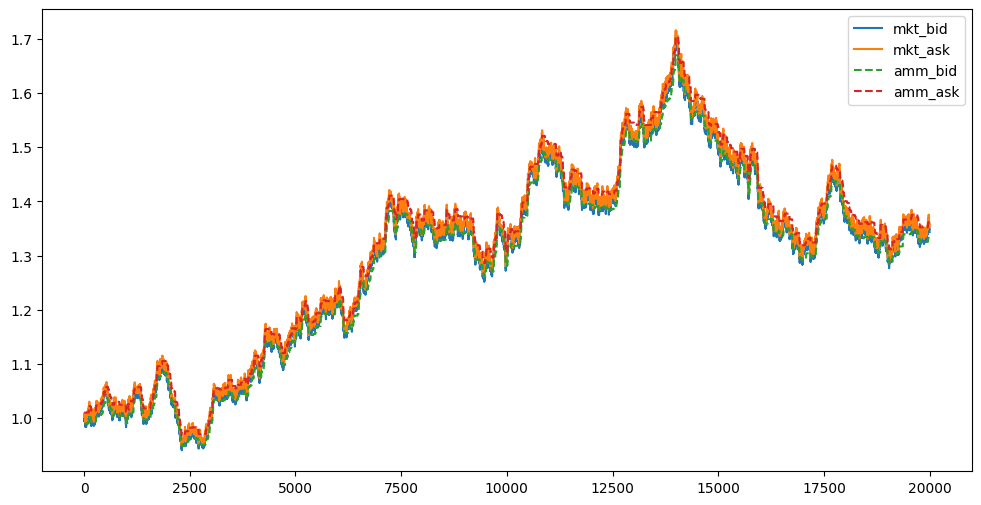

In [1]:
import os
import sys
# add /home/shiftpub/Dynamic_AMM as a path
sys.path.append(os.path.join(os.getcwd(), '..'))
from env.amm import AMM
from env.oracle import OracleSimulator
from env.trader import Arbitrager

from matplotlib import pyplot as plt


oracle = OracleSimulator(spread=1, sigma=0.5)
amm = AMM(distribute=True, fee=0.01)
trader = Arbitrager(amm, oracle)

mkt_bids = []
mkt_asks = []
amm_bids = []
amm_asks = []
swap_infos = []


for _ in range(20000):
    mkt_ask, mkt_bid = oracle.get_price()
    amm_ask, amm_bid = amm.get_price()
    mkt_bids.append(mkt_bid)
    mkt_asks.append(mkt_ask)
    amm_bids.append(amm_bid)
    amm_asks.append(amm_ask)
    
    swap_info = trader.swap()
    swap_infos.append(swap_info)
    oracle.next()

plt.figure(figsize=(12, 6))
plt.plot(mkt_bids, label='mkt_bid')
plt.plot(mkt_asks, label='mkt_ask')
plt.step(range(len(amm_bids)), amm_bids, label='amm_bid', linestyle='--', where='pre')
plt.step(range(len(amm_asks)), amm_asks, label='amm_ask', linestyle='--', where='pre')
plt.legend()
plt.show()
    

In [2]:
import numpy as np

# choose swap info where xr != 0
swap_infos = [swap_info for swap_info in swap_infos if swap_info['xr'] != 0]
# select 'amm_ask', 'amm_bid', 'mkt_ask', 'mkt_bid', 'prev_amm_ask', 'prev_amm_bid', 'xr'
swap_infos = [{key: swap_info[key] for key in ['amm_ask', 'amm_bid', 'mkt_ask', 'mkt_bid', 'prev_amm_ask', 'prev_amm_bid', 'xr']} for swap_info in swap_infos]
# check whether if xr<0 and amm_ask is very close to mkt_bid or xr>0 and amm_bid is very close to mkt_ask
# check how many times this does not hold
count = 0
for swap_info in swap_infos:
    if swap_info['xr'] < 0 and np.abs(swap_info['amm_ask'] - swap_info['mkt_bid']) > 1e-10:
        count += 1
    if swap_info['xr'] > 0 and np.abs(swap_info['amm_bid'] - swap_info['mkt_ask']) > 1e-10:
        count += 1

print(count)

0


impermanent_gains: {'IG': [-3226.1993256807327, -3169.508962035179, -3113.0799095630646, -3056.9121544361115, -3001.0056849718094, -2945.360487818718, -2889.976550579071, -2834.853860616684, -2779.9924051761627, -2725.392171382904, -2671.053146839142, -2616.9753184318542, -2563.1586742401123, -2509.6032009124756, -2456.3088858127594, -2403.2757165431976, -2350.503680229187, -2297.9927644729614, -2245.7429560422897, -2193.7542428970337, -2142.0266119241714, -2090.5600504875183, -2039.3545460700989, -1988.4100859165192, -1937.7266573905945, -1887.3042478561401, -1837.1428443193436, -1787.2424347400665, -1737.6030058860779, -1688.2245453596115, -1639.1070404052734, -1590.250478386879, -1541.6548466682434, -1493.3201323747635, -1445.2463232278824, -1397.4334062337875, -1349.8813689947128, -1302.5901985168457, -1255.55988240242, -1208.7904080152512, -1162.281762599945, -1116.0339334011078, -1070.0469080209732, -1024.320673584938, -978.8552176952362, -933.6505272388458, -888.7065899372101, -

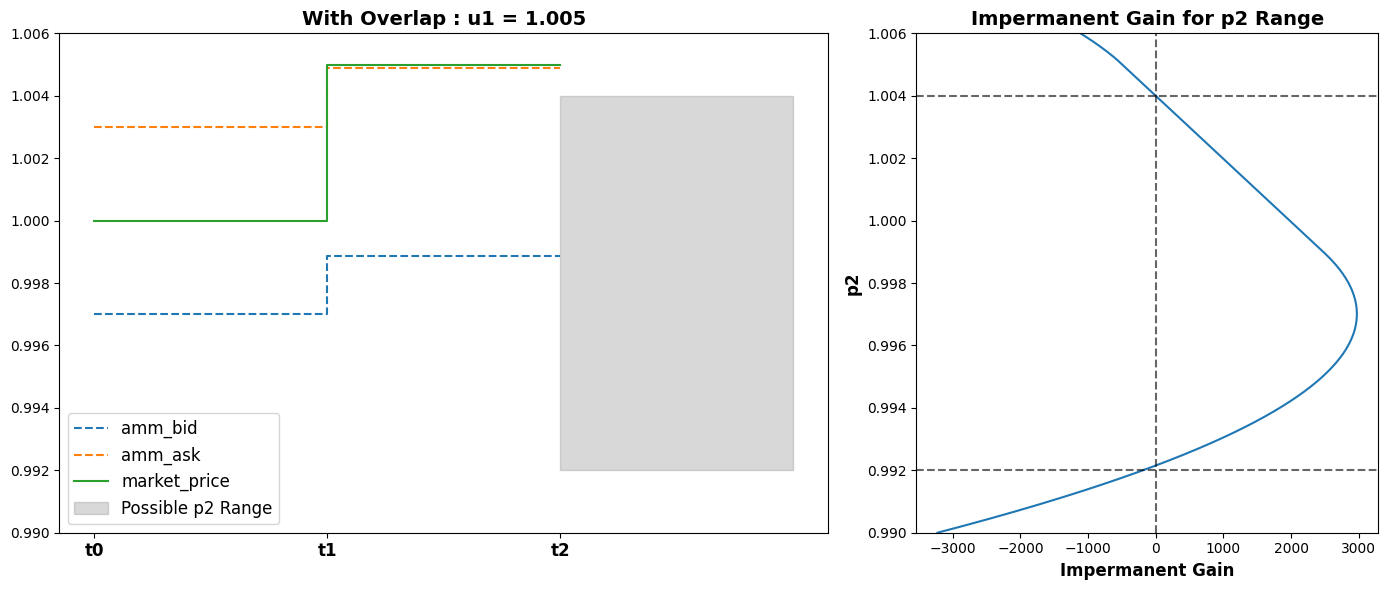

In [15]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt

# Add path for module import
sys.path.append(os.path.join(os.getcwd(), '..'))
from env.amm import AMM
from env.oracle import OracleSimulator
from env.trader import Arbitrager

# Initialize lists to store prices and impermanent loss
amm_bids = []
amm_asks = []
market_bids = []
market_asks = []
ils = []


# Initialize the AMM, Oracle, and Trader
oracle = OracleSimulator(spread=0, sigma=1)
amm = AMM(distribute=False)
trader = Arbitrager(amm, oracle)
# Calculate range for p2 based on the given formula
fee_rate = amm.f
u1 = 1.005
# u2_lower = (1 - fee_rate) / u1
u2_lower = 0.992/u1
a = 1 - fee_rate
num1 = np.sqrt((a+1)**2 - 4*a*(1-u1*a))
u2_upper = (np.sqrt((a+1)**2 - 4*a*(1-u1*a)) - (a-1)) / (2*u1*a)
# u2_upper = (np.sqrt(u1 * (1 - fee_rate)) - 1) / (u1 - np.sqrt(u1 / (1 - fee_rate)))
p2_upper = u1 * u2_upper
p2_lower = u1 * u2_lower
p2_values = np.linspace(p2_lower, p2_upper, 500)  # Sample 50 points within the p2 range

# Calculate impermanent gain (IG) for a range of p2 values
# u2_values = np.linspace(u2_lower, u2_upper, 500)  # Sample 50 points within the p2 range
u2_values = np.linspace(0.990/u1, 1.006/u1, 500)  # Sample 50 points within the p2 range
impermanent_gains = {
    'IG': [],
    'p2': []
}

for u2 in u2_values:
    oracle = OracleSimulator(spread=0, sigma=1)
    amm = AMM(distribute=False)
    trader = Arbitrager(amm, oracle)
    # Record initial prices and calculate initial impermanent loss
    amm_ask, amm_bid = amm.get_price()
    market_ask, market_bid = oracle.get_price()
    amm_bids.append(amm_bid)
    amm_asks.append(amm_ask)
    market_bids.append(market_bid)
    market_asks.append(market_ask)
    ils.append(0)
    amm_bids.append(amm_bid)
    amm_asks.append(amm_ask)
    market_bids.append(market_bid)
    market_asks.append(market_ask)
    ils.append(0)

    # Step 1: Market price changes by u1
    u1 = 1.005
    oracle.pr *= u1
    trader.swap()
    amm_ask, amm_bid = amm.get_price()
    market_ask, market_bid = oracle.get_price()
    amm_bids.append(amm_bid - 0.0001)
    amm_asks.append(amm_ask - 0.0001)
    market_bids.append(market_bid)
    market_asks.append(market_ask)
    ils.append((oracle.pr * amm.lr + oracle.ps * amm.ls) - (oracle.pr * amm.initial_lr + oracle.ps * amm.initial_ls))

    oracle.pr *= u2
    trader.swap()
    # Calculate IG based on the provided formula
    IG = (oracle.pr * amm.lr + oracle.ps * amm.ls) - (oracle.pr * amm.initial_lr + oracle.ps * amm.initial_ls)
    p2 = u1 * u2
    impermanent_gains['IG'].append(IG)
    impermanent_gains['p2'].append(p2)
print(f"impermanent_gains: {impermanent_gains}")
# Plotting
fig, axes = plt.subplots(1, 2, figsize=(14, 6), gridspec_kw={'width_ratios': [1, 0.6]})

# Left subplot with shaded area for valid p2 range
amm_bids[3] = None
amm_asks[3] = None
market_bids[3] = None
plt.sca(axes[0])
plt.step(range(4), amm_bids[:4], label='amm_bid', linestyle='--', where='pre')
plt.step(range(4), amm_asks[:4], label='amm_ask', linestyle='--', where='pre')
plt.step(range(4), market_bids[:4], label='market_price', linestyle='-', where='pre')

# Shade the area for valid p2 range
axes[0].fill_between([2, 3], p2_lower, p2_upper, color='gray', alpha=0.3, label='Possible p2 Range')
plt.xticks([0, 1, 2], ["t0", "t1", "t2"], fontsize=12, fontweight='bold')
# set y limit from 0.99 to 1.06
plt.ylim(0.990, 1.006)
axes[0].legend(fontsize=12)
axes[0].set_title("With Overlap : u1 = 1.005", fontsize=14, fontweight='bold')

# Right subplot: bar chart of impermanent gains for each p2
plt.sca(axes[1])
# u2_values = np.linspace(0.995/u1, 1.006/u1, 500)  # Sample 50 points within the p2 range
axes[1].plot(impermanent_gains['IG'], impermanent_gains['p2'])
axes[1].set_xlabel("Impermanent Gain", fontsize=12, fontweight='bold')
axes[1].set_ylabel("p2", fontsize=12, fontweight='bold')
plt.ylim(0.990, 1.006)
axes[1].set_title("Impermanent Gain for p2 Range", fontsize=14, fontweight='bold')
axes[1].axvline(x=0, color='black', linestyle='--', alpha=0.6)
axes[1].axhline(y=p2_lower, color='black', linestyle='--', alpha=0.6)
axes[1].axhline(y=p2_upper, color='black', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()
